# Overview figure

This notebook creates all subfigures related to the first and second figures in the manuscript.


In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os
import string

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']

traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")

    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)

# Load overall data
trace_overall = load("/data.nst/smohr/covid19_soccer_data/trace_overall_effekt.pkl")
alpha_overall = load("/data.nst/smohr/covid19_soccer_data/trace_overall_alpha.pkl")

# Load counterfactual
file = "/data.nst/smohr/covid19_soccer_data/counterfactual/Czechia_with_England_participation.pkl"
(trace_czechia_with_england_participation,
 trace_czechia_with_england_participation_no_soccer,
 trace_czechia_with_england_participation_primary) = load(file)

file = "/data.nst/smohr/covid19_soccer_data/counterfactual/England_only_groupstage.pkl"
trace_only_GS, trace_only_GS_no_soccer, trace_only_GS_primary = load(file)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Italy
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for Belgium
Use 4000 sample runs for France
Use 4000 sample runs for Portugal
Use 4000 sample runs for Netherlands


In [3]:
infections_no = []
infections_primary = []
infections_subsequent = []
for i, country in enumerate(countries):
    shape = traces_without_soccer[i].predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = get_from_trace("new_cases",traces_without_soccer[i],from_type="predictions")
    y1 = get_from_trace("new_cases",traces_primary_soccer[i],from_type="predictions") - y0
    y2 = get_from_trace("new_cases",traces[i]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_subsequent.append(y2)
    
data_primary  = pd.DataFrame()
medians = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100
    print(t_numpy.shape)
    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    medians.append(np.median(temp["percentage_primary"]))
country_order_primar = np.argsort(medians)[::-1]

data_primary_and_subsequent = pd.DataFrame()
medians = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_subsequent[i])/(infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    medians.append(np.median(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(medians)[::-1]


# Compute interesting values as fraction, as incidence and as cases
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country"])
    temp_m = temp[temp["gender"]=="male"].drop(columns=["gender"])
    temp_f = temp[temp["gender"]=="female"].drop(columns=["gender"])
    primary_frac.append(np.array([temp_m.to_numpy()[:,0],temp_f.to_numpy()[:,0]]))
primary_frac.insert(0,get_from_trace("overall_effect",trace_overall).T) # insert total effect at front

primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])

primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp / dls[i].population[0]*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_inci.append(temp/ dls[i].population[0]*1e6)

primary_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_cases.append(temp)

primary_and_subsequent_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_cases.append(temp)
    

(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(28000, 2)
(32000, 2)
(32000, 2)


In [4]:
from covid19_soccer.plot.other import MulticolorPatch, MulticolorPatchHandler, Line2D, Rectangle, HandlerRect, rcParams
from covid19_soccer.plot.utils import k_formatter, MinorSymLogLocator
import string

def get_xy(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0
    
    y = [
        y0[:,0]+y0[:,1],
        y1[:,0]+y1[:,1],
        y2[:,0]+y2[:,1]
    ]
    return x, y
def plot_legend(ax,loc="upper left",data=False,model=False,primary=True):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    if data:
        handles.append(Line2D(
                    [0],
                    [0],
                    color="black",
                    ls="none",
                    lw=0,
                    marker="d",
                    ms=3.5
                ))
        labels.append("Observed\ncases") 
    if model:
        handles.append(
            Line2D(
                [0],
                [0],
                color=rcParams.color_model,
                lw=2,
            )
        )
        labels.append("Model")
    
    """
    handles.append(MulticolorPatch([colors_base[1]]))
    labels.append("Source of\ninfection:")
    """
    if primary:
        handles.append(MulticolorPatch([colors_base[1]]))
        labels.append("Primary\ncases")

        handles.append(MulticolorPatch([colors_base[2]]))
        labels.append("Subsequent\ncases")

        handles.append(MulticolorPatch([colors_base[0]]))
        labels.append("Independent\ncases")

    #handles.append(Rectangle([0,0],width=1, height=2.2, lw=1, edgecolor=rcParams.color_championship_range,hatch="////",facecolor = 'none'))
    #labels.append("Time window of\nthe championship") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax


def get_primary_and_subsequent(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    y0 = get_from_trace("new_cases",trace_without_soccer,from_type="predictions")
    y1 = get_from_trace("new_cases",traces_primary_soccer[i],from_type="predictions") - y0
    y2 = get_from_trace("new_cases",trace) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    
    y0 = np.sum(y0[..., i_begin:i_end, :], axis=(-2,-1)) #no soccer
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=(-2,-1)) #primary
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=(-2,-1)) #subsequent

    return y1+y2 

def whisker_plot_v(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="y",bottom=False)



## Figure1: Grid of model fits and counterfactuals



[206.23439525  82.22821126 511.33802152]


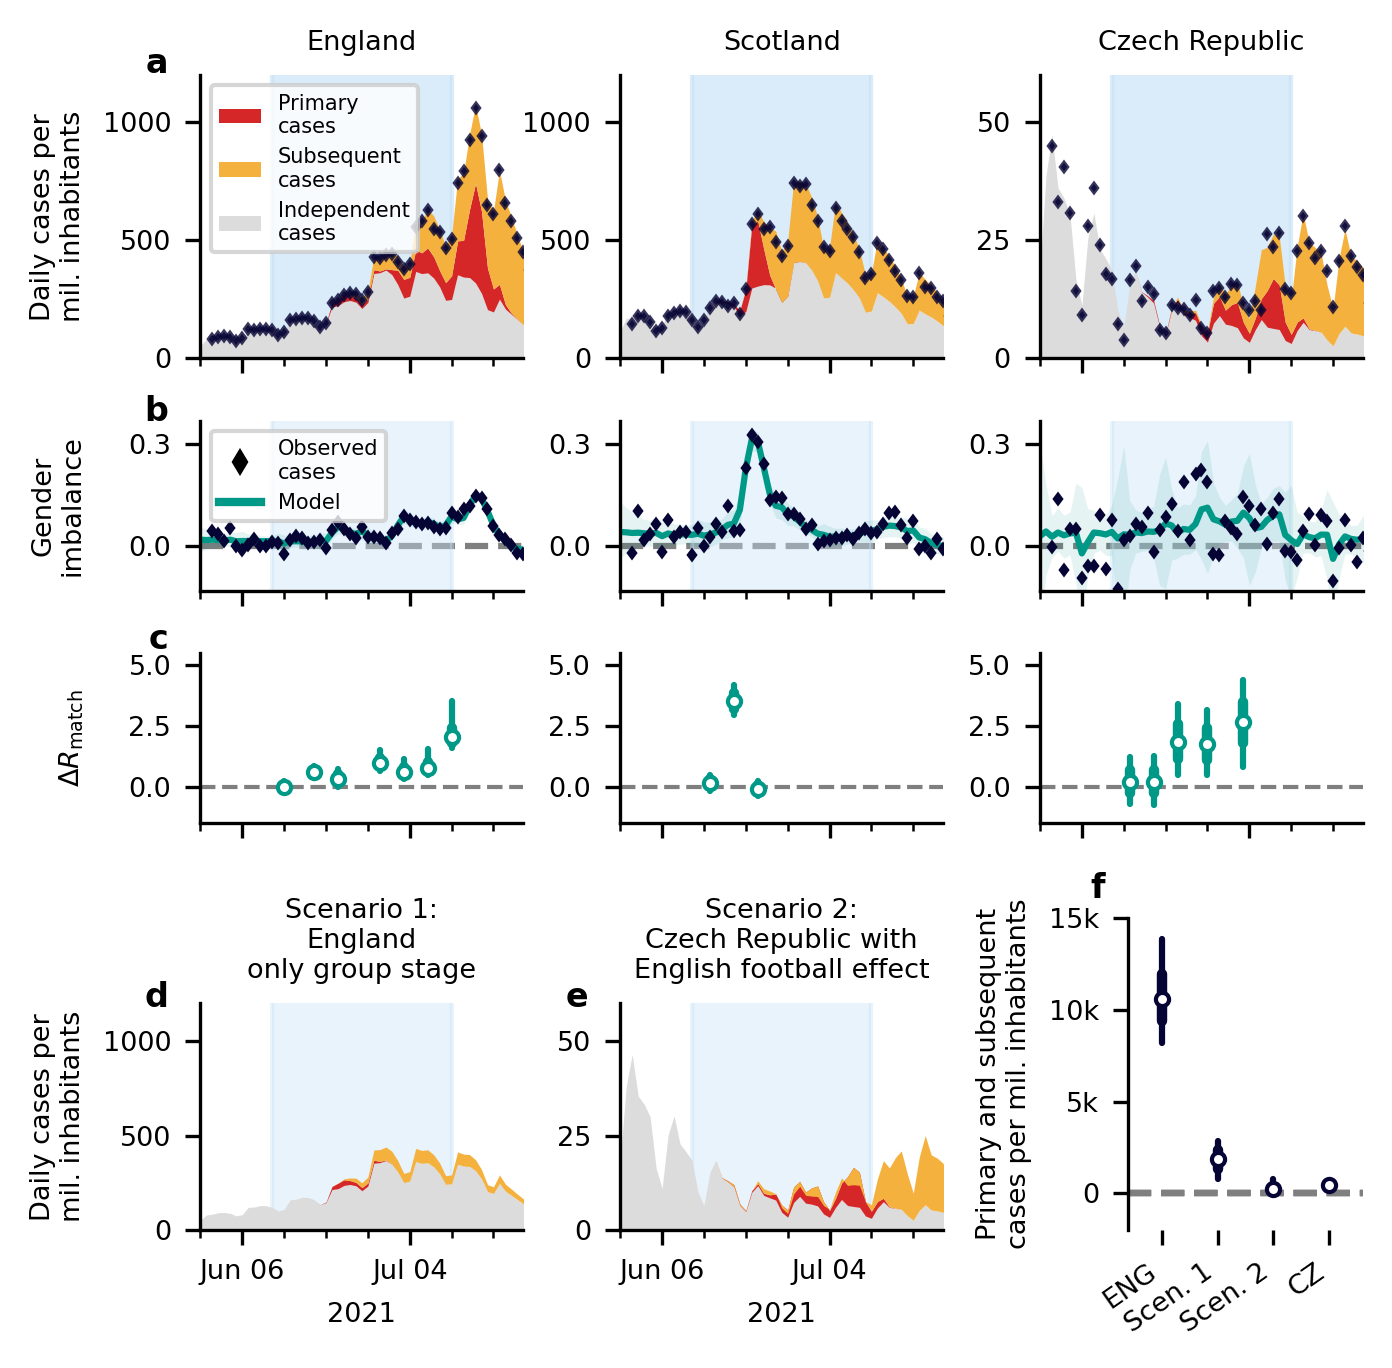

In [17]:
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female
from covid19_soccer.plot.other import game_effects
from covid19_soccer.plot.other import format_date_axis
import matplotlib.gridspec as gridspec

import string

plt.close("all")
colors_base = ["gainsboro","tab:red","#f5b13d"]
xlim_ts = [ # Plotting x lims
    datetime.datetime(2021,5,30),
    datetime.datetime(2021,7,23)
] 
gridspec_ = { # Layout
    "wspace": 0.4,
    "hspace": 0.2,
    "width_ratios":[1,1,0.3,0.7],
    "height_ratios": [3,1.8,1.8,1.8]
}
fig = plt.figure(figsize=(5,5))

gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios = [6,2.5],hspace=0.18)

# Layout for first three rows
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0], height_ratios=[3,1.8,1.8],hspace=0.3,wspace=0.3)
axes = []
for i in range(3):
    axes_t = []
    for j in range(3):
        axes_t.append( fig.add_subplot(gs00[i,j]))
    axes.append(axes_t)
axes = np.array(axes)


# Layout for last row
gs10 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1],wspace=0.3,height_ratios=[0.2,0.8])
axes_last = []
for i in range(3):
    if i != 2:
        axes_last.append(fig.add_subplot(gs10[1,i]))
    else:
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs10[:,2],width_ratios=[0.2,0.8])
        
        axes_last.append(fig.add_subplot(gs[1]))

# First row
for i, ax in zip([0,2,1],axes[0,:]):
    # Show time of uefa championship
    x , y = get_xy(traces[i],traces_without_soccer[i],traces_primary_soccer[i])
    for j in range(len(y)):
        y[j] = y[j]/dls[i].population[0]*1e6
    
    _uefa_range(ax)
    incidence(ax, traces[i], models[i], dls[i],lw=0.5,color="none")
    stacked_filled(
        x,
        [yi/2 for yi in y],
        ax=ax,
        colors=colors_base,
        label="b",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title(countries[i] if countries[i] != "Czechia" else "Czech Republic")
    ax.set_xlim(*xlim_ts)
    if i == 0:
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
        plot_legend(ax)
        ax.set_ylim(0,1200)
        ax.set_yticks([0,500,1000])
    if i == 2:
        ax.set_ylim(0,1200)
        ax.set_yticks([0,500,1000])
    if i == 1:
        ax.set_ylim(0,60)
        ax.set_yticks([0,25,50])      
        
# Second row
for i,ax in zip([0,2,1],axes[1,:]):
    fraction_male_female(ax,traces[i],models[i],dls[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_xlim(*xlim_ts)
    if i == 0:
        ax.set_ylabel("Gender\nimbalance")
        plot_legend(ax,primary=False,data=True,model=True)
    ax.set_ylim(-0.13,0.37)
    ax.set_yticks([0,0.3])

    
# Third row
for i,ax in zip([0,2,1],axes[2,:]):
    game_effects(ax,traces[i],models[i],dls[i],type="bars")
    ax.set_xlim(*xlim_ts)
    ax.set_ylim(-1.5,5.5)
    ax.set_xticklabels([])
    ax.set_yticks([0,2.5,5])
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel("$\Delta R_\mathrm{match}$")
    
#Forth row
for i, ax in enumerate(axes_last):
    if i == 0:
        # Counterfactual scenario 1
        x, y = get_xy(trace_only_GS,trace_only_GS_no_soccer,trace_only_GS_primary)
        for j in range(len(y)):
            y[j] = y[j]/np.sum(dls[0].population)*1e6

        _uefa_range(ax)
        stacked_filled(
            x,
            [yi for yi in y],
            ax=ax,
            colors=colors_base,
            label="b",
        )
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
        ax.set_xlim(*xlim_ts)
        ax.set_title("Scenario 1:\nEngland\nonly group stage")
        ax.set_ylim(0,1200)
        ax.set_yticks([0,500,1000])
        ax.set_xlabel("2021")
    if i == 1:
        x, y = get_xy(
            trace_czechia_with_england_participation,
            trace_czechia_with_england_participation_no_soccer,
            trace_czechia_with_england_participation_primary
        )

        for j in range(len(y)):
            y[j] = y[j]/np.sum(dls[1].population)*1e6

        _uefa_range(ax)

        stacked_filled(
            x,
            [yi for yi in y],
            ax=ax,
            colors=colors_base,
            label="b",
        )
        # Counterfactual scenario 2
        ax.set_ylim(0,60)
        ax.set_yticks([0,25,50])
        #axes[1].set_ylabel("Daily cases per\nmil. inhabitants")
        ax.set_xlim(*xlim_ts)
        ax.set_title("Scenario 2:\nCzech Republic with\nEnglish football effect")
        ax.set_xlabel("2021")
    if i == 4:
        ax.set_axis_off()
    if i == 2:
        traces_for_panel = [
            (traces[0], traces_without_soccer[0],traces_primary_soccer[0]), # England
            (trace_only_GS,trace_only_GS_no_soccer,trace_only_GS_primary),
            (trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary), 
            (traces[1], traces_without_soccer[1],traces_primary_soccer[1]) # Czechia
        ]
        temp = []
        for j, (t_traces,dl) in enumerate(zip(traces_for_panel,[dls[0],dls[0],dls[1],dls[1]])):
            cases_primary_and_subs = get_primary_and_subsequent(*t_traces)
            temp.append(cases_primary_and_subs)
            inci_primary_and_subs = cases_primary_and_subs/np.sum(dl.population)*1e6
            
            # calc percentiles
            m,l2,l1,u1,u2 = np.percentile(inci_primary_and_subs,q=(50,2.5,50-34,50+34,97.5))
            # Plot
            whisker_plot_v(ax,j,m,l2,u2,l1,u1)
        print(np.percentile(temp[0]/temp[2],q=(50,2.5,97.5)))
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(["ENG","Scen. 1", "Scen. 2", "CZ"],rotation=35,ha="right")
        ax.set_ylabel("Primary and subsequent\ncases per mil. inhabitants")
        ax.set_ylim(-2000,15000)
        ax.set_xlim(-0.6, 3.6)
        ax.yaxis.set_major_formatter(k_formatter)
        
        
# Axis labels
axes[0,0].text(
    -0.1,
    1.1,
    "a",
    transform=axes[0,0].transAxes,
    fontsize=8,
    fontweight="bold",
    va="top",
    ha="right",
)    
axes[0,0].text(
    -0.1,
    1.15,
    "b",
    transform=axes[1,0].transAxes,
    fontsize=8,
    fontweight="bold",
    va="top",
    ha="right",
)   
axes[0,0].text(
    -0.1,
    1.175,
    "c",
    transform=axes[2,0].transAxes,
    fontsize=8,
    fontweight="bold",
    va="top",
    ha="right",
)   

axes_last[0].text(
        -0.1,
        1.1,
        "d",
        transform=axes_last[0].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
) 
axes_last[1].text(
        -0.1,
        1.1,
        "e",
        transform=axes_last[1].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
)     
axes_last[2].text(
        -0.1,
        1.15,
        "f",
        transform=axes_last[2].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
)     
fig.align_ylabels([axes[0,0],axes[1,0],axes[2,0],axes_last[0]])
fig.savefig(f"../figures/overview_examples.pdf", **save_kwargs)
fig.savefig(f"../figures/overview_examples.png", **save_kwargs)
plt.show()

Old plot

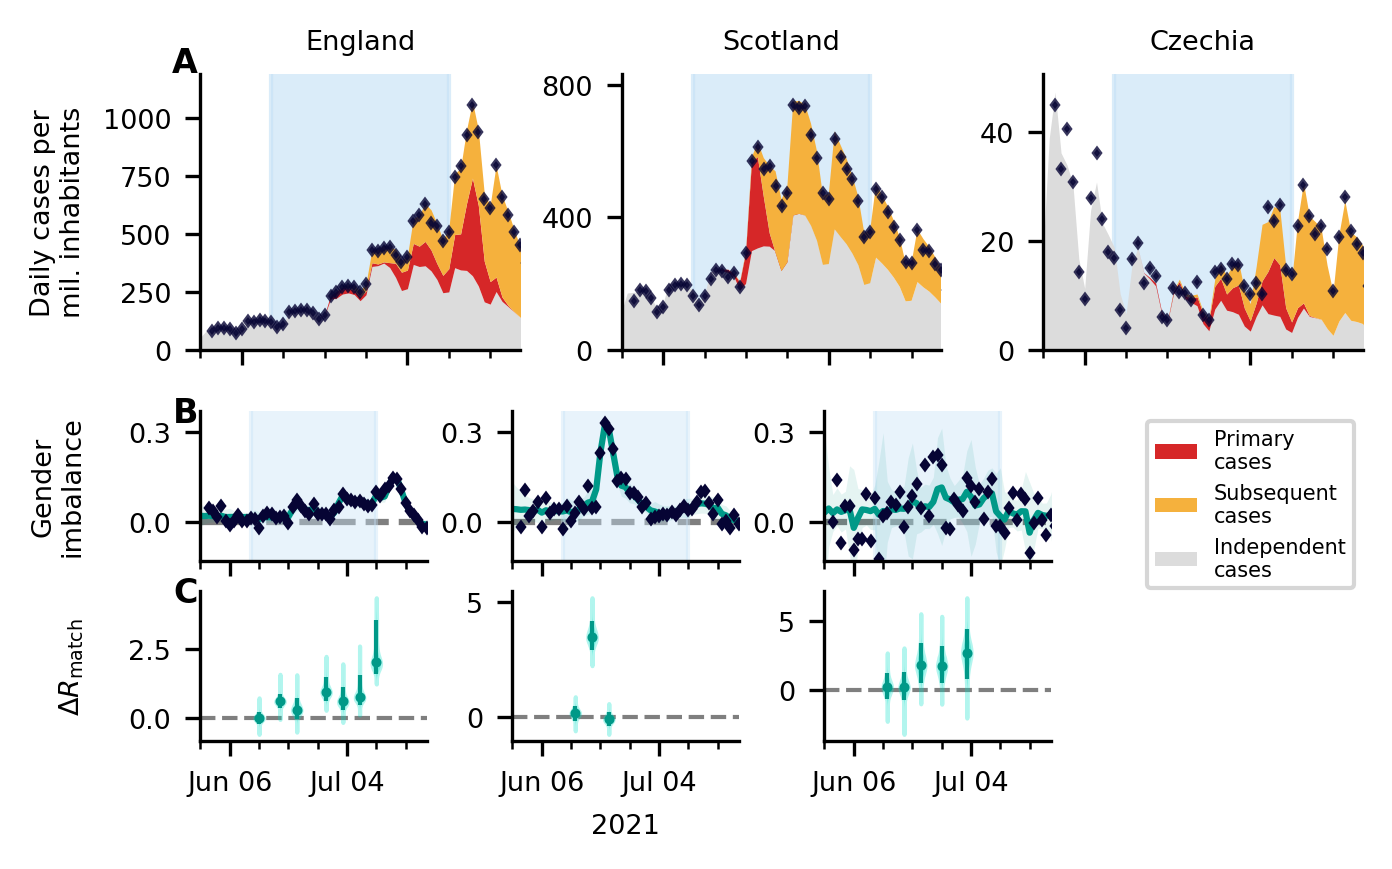

In [18]:
plt.close('all')
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(4.75,3))

gs = gridspec.GridSpec(2, 1, height_ratios=[3,1.8*2], )

gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=gs[0],wspace=0.32)
gs2 = gridspec.GridSpecFromSubplotSpec(2,4,subplot_spec=gs[1],wspace=0.38)

axes_r1 = []
axes_r1.append(plt.subplot(gs1[0]))
axes_r1.append(plt.subplot(gs1[1]))
axes_r1.append(plt.subplot(gs1[2]))
# First row
for i, ax in zip([0,2,1],axes_r1):
    # Show time of uefa championship
    x , y = get_xy(traces[i],traces_without_soccer[i],traces_primary_soccer[i])
    for j in range(len(y)):
        y[j] = y[j]/dls[i].population[0]*1e6
    
    _uefa_range(ax)
    incidence(ax, traces[i], models[i], dls[i],lw=0.5,color="none")
    stacked_filled(
        x,
        [yi/2 for yi in y],
        ax=ax,
        colors=colors_base,
        label="b",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title(countries[i])
    ax.set_xlim(*xlim_ts)
    if i == 0:
        ax.set_ylabel("Daily cases per\nmil. inhabitants")
    if i == 2:
        ax.set_yticks([0,400,800])

axes_r2 = []
axes_r2.append(plt.subplot(gs2[0,0]))
axes_r2.append(plt.subplot(gs2[0,1]))
axes_r2.append(plt.subplot(gs2[0,2]))
# Second row
for i,ax in zip([0,2,1],axes_r2):
    fraction_male_female(ax,traces[i],models[i],dls[i])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_xlim(*xlim_ts)
    if i == 0:
        ax.set_ylabel("Gender\nimbalance")
    ax.set_ylim(-0.13,0.37)
    ax.set_yticks([0,0.3])

axes_r3 = []
axes_r3.append(plt.subplot(gs2[1,0]))
axes_r3.append(plt.subplot(gs2[1,1]))
axes_r3.append(plt.subplot(gs2[1,2]))
# Third row
for i,ax in zip([0,2,1],axes_r3):
    game_effects(ax,traces[i],models[i],dls[i])
    ax.set_xlim(*xlim_ts)
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel("$\Delta R_\mathrm{match}$")
    if i == 2:
        ax.set_xlabel("2021")
    
ax_legend = plt.subplot(gs2[:,3])
ax_legend.axis("off")
plot_legend(ax_legend)
plt.tight_layout()

 # Axis labels
alphabet_string = list(string.ascii_uppercase)
for i,ax in enumerate([axes_r1[0],axes_r2[0],axes_r3[0]]):
    letter = alphabet_string[i]
    ax.text(
        -0.01,
        1.1,
        letter,
        transform=ax.transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )       
        
fig.align_ylabels([axes_r1[0],axes_r2[0],axes_r3[0]])

plt.show()
#fig.savefig(f"./figures/overview_examples_old.pdf", **save_kwargs)
#firstfig.savefig(f"./figures/overview_examples_old.png", **save_kwargs)
plt.close("all")

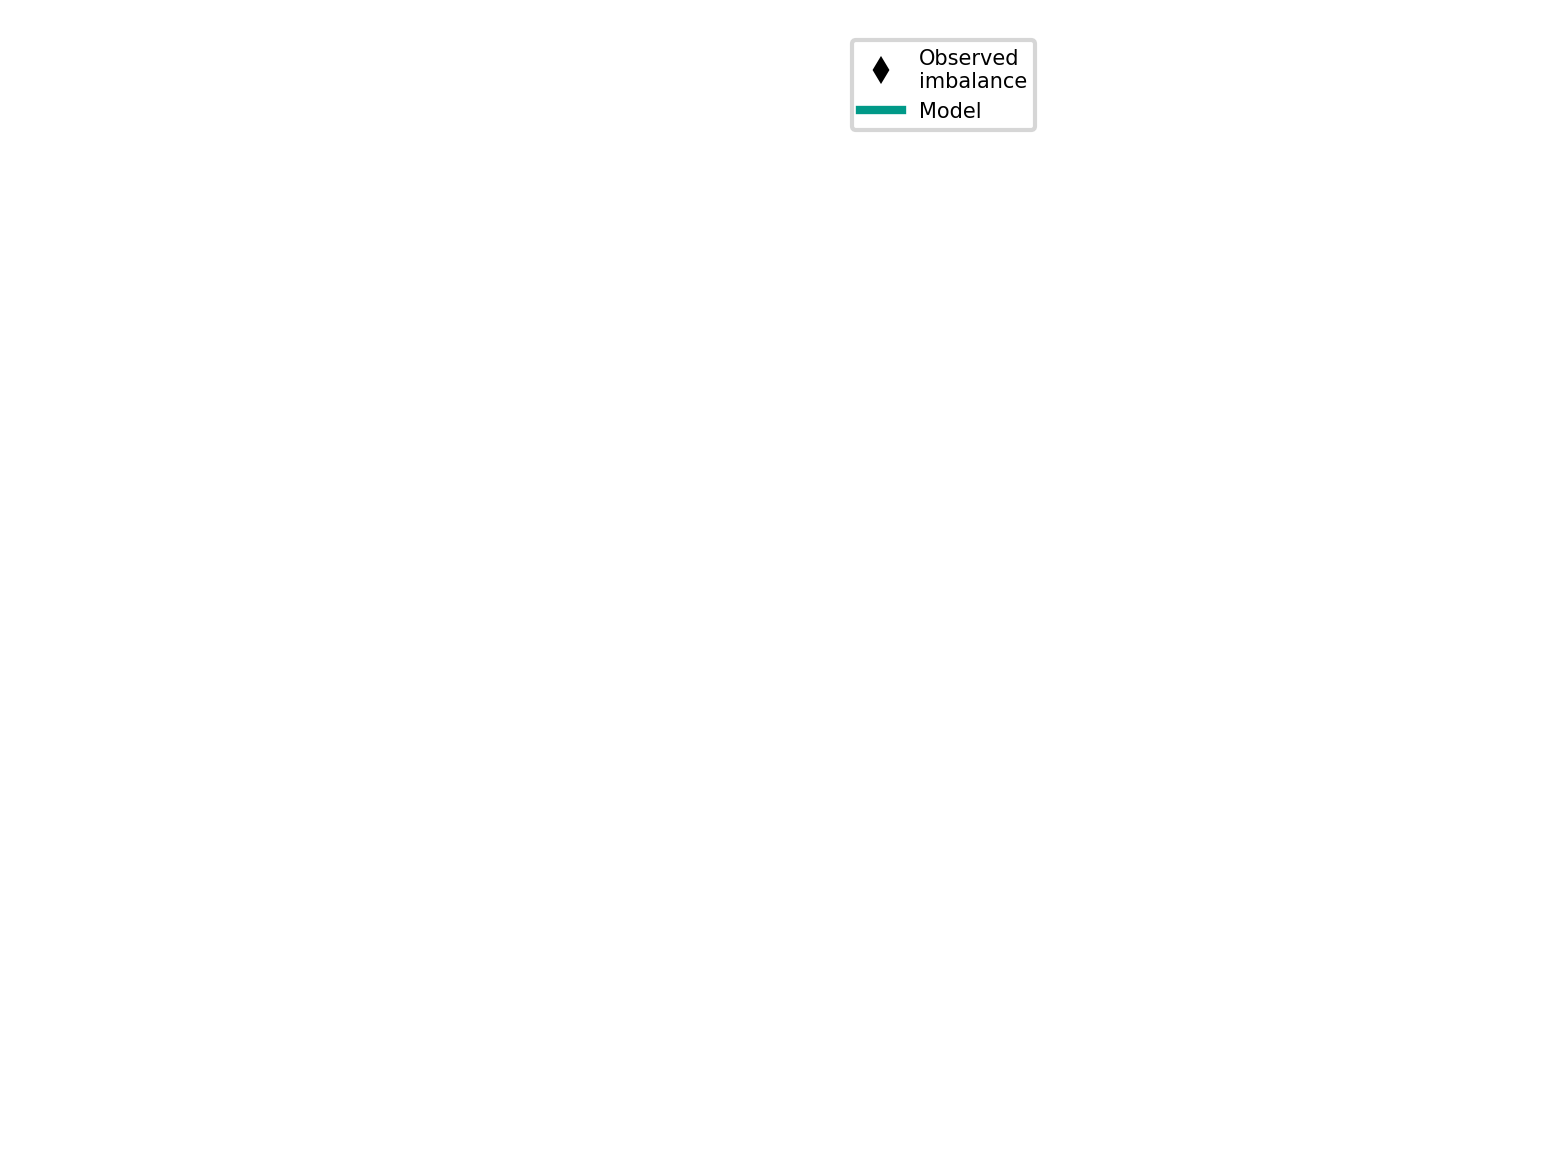

In [21]:
# Create legend
def plot_legend_1(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(Line2D(
                [0],
                [0],
                color="black",
                ls="none",
                lw=0,
                marker="d",
                ms=3.5
            ))
    labels.append("Observed\nimbalance") 
    handles.append(
        Line2D(
            [0],
            [0],
            color=rcParams.color_model,
            lw=2,
        )
    )
    labels.append("Model")

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax
fig,ax = plt.subplots(1,2)
ax[0].axis("off")
ax[1].axis("off")
#plot_legend_0(ax[0])
plot_legend_1(ax[1])
fig.savefig(f"./figures/overview_eng_sct_cz_legend.pdf", **save_kwargs)
fig.savefig(f"./figures/overview_eng_sct_cz_legend.png", **save_kwargs)
plt.show()

## Part2: Violins and totals


In [52]:
from covid19_soccer.plot.utils import k_formatter, MinorSymLogLocator
import string

def reduce_samples(curr_list):
    number_of_samples = 20000
    temp = []
    for i, array in enumerate(curr_list):
        array = array[np.random.choice(array.shape[0], number_of_samples, replace = False),...]
        temp.append(array)
    return np.array(temp)

def whisker_plot(ax,y,x_median,x_lower_95,x_upper_95,x_lower_68,x_upper_68):
    lines = ax.hlines(
        y=y,
        xmin=x_lower_95,
        xmax=x_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.hlines(
        y=y,
        xmin=x_lower_68,
        xmax=x_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        y=y,
        x=x_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axvline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis="y",left=False)

In [53]:
# Layout
gridspec = { # Layout
    "wspace": 0.15,
    "width_ratios":[1,1.618,1],
}
fig, axes  = plt.subplots(1, 3, figsize=(7,3.5), gridspec_kw=gridspec)
#grid = fig.add_gridspec(2, 1, hspace=0.28, height_ratios=[3,2],)

#ax1 = fig.add_subplot(grid[0, 0])
#ax2 = fig.add_subplot(grid[1, 0])
#ax3 = fig.add_subplot(outer_grid[0, 1])
X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
X.insert(0, "Avg.")


In [54]:
from covid19_soccer.plot.rcParams import *

ax0 = axes[0]

# Plot overall first
dat = get_from_trace("overall_alpha",alpha_overall)
m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,50-34,50+34,97.5))
whisker_plot(ax0,"Avg.",m,l2,u2,l1,u1)

for i, (trace, country) in enumerate(zip(traces,countries)):
    # Get datapoints
    dat = get_from_trace("alpha_mean",trace)
    
    m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,50-34,50+34,97.5))

    whisker_plot(ax0,country,m,l2,u2,l1,u1)

ax0.set_ylim(12.6,-1.1)
ax0.set_xlabel("Mean match effect\n$\Delta R_\mathrm{match}^\mathrm{mean}$")
ax0.axvline(0,ls="--",color="tab:gray")
ax0.set_yticklabels([]);
ax0.set_xticks([-2.5,0,2.5,5])

In [55]:
from covid19_soccer.plot.other import soccer_related_cases_overview, vviolins
ax1 = axes[1]


vviolins(
        ax1,
        countries,
        primary_frac,
)

ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac]
ci = np.array(ci).T
whisker_plot(ax1,X,ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:])
print(ci)

ax1.set_xlim(-20,29)
ax1.set_ylim(12.6,-1.1)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.tick_params(axis="y", which="major", pad=16, length=0)
ax1.set_xlabel("Primary cases (% of all observed\ncases, from 11th June to 31st July) ")


# Add legend
from covid19_soccer.plot.other import legend

legend(
    ax=ax1,
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="lower right",
)

[[ 0.50363893  5.58576796  3.31616095  1.26156115 -1.10056529 -5.7614399
  -7.66324737 -1.83752082 -2.23548779 -2.31430799 -0.1523841  -2.57400605
  -3.25109686]
 [ 2.9749614  12.40873467  9.70144159  3.28448552  2.83119775  2.1323913
   1.56913254  1.38144474  1.1840508   0.55652488  0.51215963  0.26781116
  -1.46212308]
 [ 6.86858715 22.45459865 16.24490825  8.13412149  9.2241272  10.86213096
  10.2136499   4.2275368   4.80766422  4.22500201  1.35144941  2.65817755
  -0.17212014]
 [ 1.68683189  7.05679882  6.49698431  1.66305141  0.78050901 -1.24436849
  -1.46501327  0.16697613 -0.2513079  -0.69140298  0.17503512 -0.83755582
  -2.34475985]
 [ 4.9184624  16.6722625  12.95123925  6.96911603  5.68168539  6.08868496
   5.32701651  2.79307178  2.85835633  2.10500813  0.9172402   1.33948415
  -0.72012818]]


/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:1259: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:1263: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


<AxesSubplot:xlabel='Primary cases (% of all observed\ncases, from 11th June to 31st July) ', ylabel='country'>

In [56]:
from covid19_soccer.plot.other import plot_flags

X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
X.insert(0, "Avg.")

plot_flags(
    ax1,
    X,
    vertical=True,
    zoom=0.019,
    ypos_flags=-20,
    adjust_align=-32.5
)

lookup_games_played = {
    "Avg.":"‒",
    "ENG":7,
    "CZ":5,
    "SCT":3,
    "ES":6,
    "IT":7,
    "SK":3,
    "DE":4,
    "AT":4,
    "BE":5,
    "FR":4,
    "PT":4,
    "NL":4
}
y_labels = [f"{x}       ({lookup_games_played[x]})" for x in X]
ax1.set_ylabel(None)

ax1.set_yticks(list(range(13)))
ax1.set_yticklabels(y_labels)

[Text(0, 0, 'Avg.       (‒)'),
 Text(0, 1, 'ENG       (7)'),
 Text(0, 2, 'CZ       (5)'),
 Text(0, 3, 'SCT       (3)'),
 Text(0, 4, 'ES       (6)'),
 Text(0, 5, 'IT       (7)'),
 Text(0, 6, 'SK       (3)'),
 Text(0, 7, 'DE       (4)'),
 Text(0, 8, 'AT       (4)'),
 Text(0, 9, 'BE       (5)'),
 Text(0, 10, 'FR       (4)'),
 Text(0, 11, 'PT       (4)'),
 Text(0, 12, 'NL       (4)')]

[ 963.03519951 2228.04437941 3301.68650858 1644.09749365 2787.27700701]


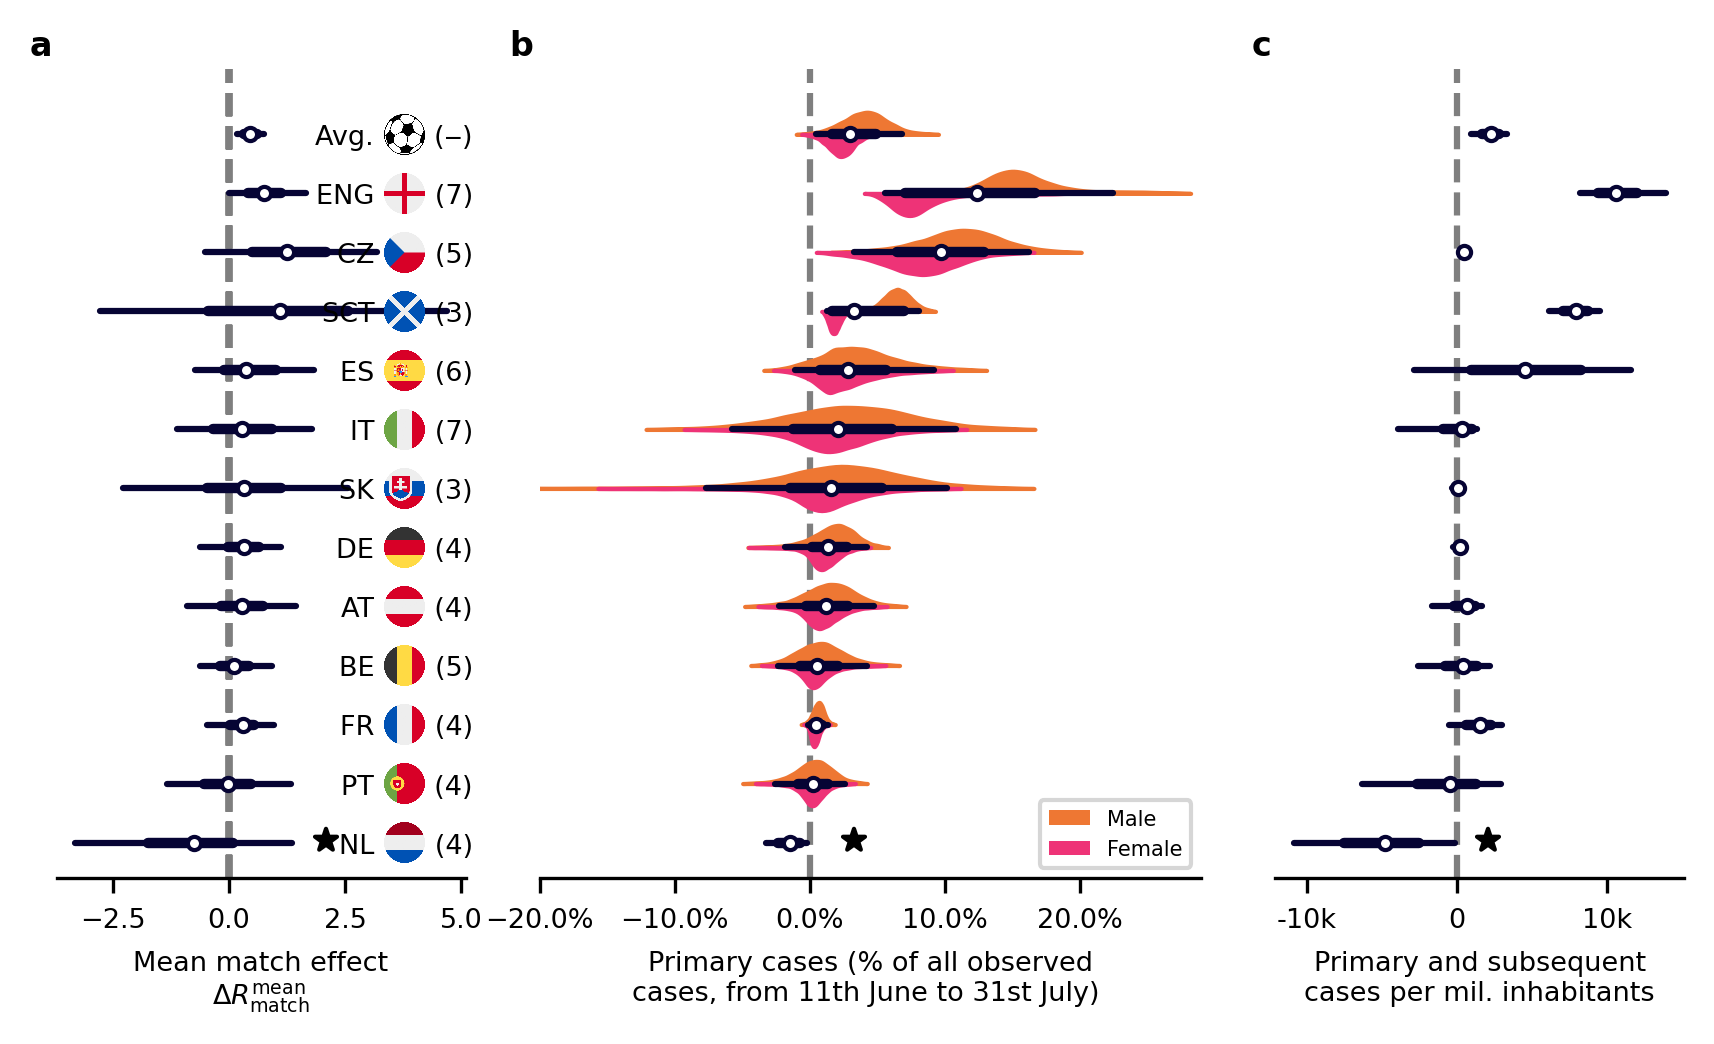

In [57]:
ax2 = axes[2]

Y = reduce_samples(primary_and_subsequent_cases).sum(axis=-1) # shape 12,n
population = np.array([dls[i].population.sum() for i,c in enumerate(countries)])

total = np.percentile(Y.sum(axis=0)/population.sum()*1e6,q=(2.5,50,97.5,50-34,50+34),axis=0)
Y = np.percentile(Y,q = (2.5,50,97.5,50-34,50+34),axis=-1) / population * 1e6

X = [dls[i].countries_iso2[0].replace("GB-","") for i, country in enumerate(countries)]
Y = np.insert(Y, 0, total ,axis=1) # Total avg
X.insert(0, "Avg.")
print(total)
whisker_plot(ax2,X,Y[1,:],Y[0,:],Y[2,:],Y[3,:],Y[4,:])

ax2.spines["bottom"].set_visible(True)
ax2.spines["left"].set_visible(False)
ax2.set_yticklabels([])
ax2.tick_params(axis="y",left=False)

#ax2.set_yscale('symlog', linthresh=1e2,base=100)
#ax2.set_yticks([-1e4,-1e2,0,1e2,1e4,1e6])
#ax2.yaxis.set_minor_locator(MinorSymLogLocator(1e2))
#ax2.set_ylim(-1e5,1e5)

def formatter(x,pos):
    if x > 1000 or x < -1000:
        return '{:,.0f}'.format(x).replace(',', ' ')
    else:
        return '{:,.0f}'.format(x)
ax2.xaxis.set_major_formatter(k_formatter)
ax2.set_ylim(12.6,-1.1)
ax2.set_xlabel("Primary and subsequent\ncases per mil. inhabitants")

# Add star to NL
ax0.scatter(2,"Netherlands",marker='$\star$',color="black",s=50)
ax1.scatter(3,12,marker='$\star$',color="black",s=50)
ax2.scatter(1800,12,marker='$\star$',color="black",s=50)

 # Axis labels
alphabet_string = list(string.ascii_lowercase)
for i in range(3):
    letter = alphabet_string[i]
    axes[i].text(
        -0.01,
        1.05,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )       
        


plt.show()
fig.savefig(f"./../figures/overview_frac_primAndSubs.pdf", **save_kwargs)
fig.savefig(f"./../figures/overview_frac_primAndSubs.png", **save_kwargs)
plt.close()

In [58]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 18 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

matplotlib       : 3.5.1
covid19_inference: 0.3.6
seaborn          : 0.11.1
sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
numpy            : 1.20.3
pandas           : 1.2.4

Watermark: 2.3.1

